# ISBI 2023: Tutorial on Topological Data Analysis
# [Soheil Kolouri](https://skolouri.github.io/), Department of Computer Science, Vanderbilt University

This tutorial focuses on the application of optimal transport and its sliced variations to comparing persistence diagrams. 



## Part 2 - Sliced Optimal Transport for Comparing Persistence Diagrams

In this part, we will focus on sliced optimal transport (SOT) as a computationally efficient alternative to OT. We will then demonstrate the application of SOT for comparing persistence diagrams.

## Part 2.1 - Optimal Transport Between One-Dimensional Measures

As previously mentioned, the OT problem between two discrete measures can be solved by optimizing linear programming. It is worth noting that this method has a cubic time complexity in the number of mass particles, which can pose a challenge in larger-scale problems. The good news is that for one-dimensional measures, there exists a closed-form solution to the OT problem. Let $\mu$ and $\nu$ be probability measures defined on $\Omega\subseteq\mathbb{R}$ and let $c(x,y)=\|x-y\|_p^p$ denote the transportation cost. Then, the OT problem can be written as: 

$$ OT(\mu, \nu)=\int_0^1 \|F_\mu^{-1}(t)-F_\nu^{-1}(t)\|_p^p dt$$

where $F_\mu(t)=\mu((-\infty,t])$ is the cumulative density function (CDF) and $F_\mu^{-1}$ denotes its inverse, also known as the quantile function. 

For one-dimensional measures $\mu(x)=\sum_{i=1}^N \delta(x-x_i)$ and $\nu(y)=\sum_{j=1}^N \delta(y-y_j)$, the optimal transport is obtained via sorting $\{x_i\}_{i=1}^N$ and $\{y_j\}_{j=1}^N$, 

$$ OT(\mu, \nu)= \sum_{i=1}^N \|x_{\sigma(i)}-y_{\kappa(j)}\|_p^p,$$

where $\sigma$ and $\kappa$ denote the sorted indices of $\{x_i\}_{i=1}^N$ and $\{y_j\}_{j=1}^N$, respectively. The figure below depicts the concept of the one-dimensional optimal transport problem. 

![OT 1D](./src/OT1D.png)
![OT 1D](./src/OT1D_discrete.png)

## Part 2.2 - Sliced Optimal Transport

The closed form solution of OT for one-dimensional probability measures motivates the introduction of Sliced Optimal Transport. The notion of slicing a d-dimensional probability measure (d>1) is deeply rooted in integral geometry and the celebrated Radon transform. Let $\mu$ be a d-dimensional probability measure defined on $\Omega\subseteq\mathbb{R}^d$, and let $\theta\in\mathbb{S}^{(d-1)}$ denote a unit vector in $\mathbb{R}^d$. Then, a one-dimensional slice of $\mu$ with respect to $\theta$ is written as $\theta_\#\mu$, s.t., $\theta_\#\mu(t)=\mu(H(t;\theta))$ and $H(t;\theta):=\{x | x\cdot \theta = t\}$. Then one can define the Sliced OT problem as follows [1]: 

$$ SOT(\mu,\nu):=\int_{\mathbb{S}^{d-1}} OT(\theta_\#\mu,\theta_\#\nu)d\sigma(\theta)$$

where $\sigma$ is a probability measure with $supp(\sigma)=\mathbb{S}^{d-1}$. In practice, we often set $\sigma$ to be the uniform measure on $\mathbb{S}^{d-1}$. Given that in practice we cannot integrate over $\mathbb{S}^{d-1}$, we use Monte Carlo integration to approximate it. In short, let $\{\theta_l\sim \mathcal{U}(\mathbb{S}^{d-1})\}_{k=1}^K$ denote $L$ i.i.d. samples from the uniform distribution on $\mathbb{S}^{d-1}$, then the above mentioned integral can be approximated via: 

$$ SOT(\mu,\nu)\approx \frac{1}{K}\sum_{k=1}^K OT((\theta_{k})_\#\mu,(\theta_k)_\#\nu)$$

The beauty of the above equation is that the summation on $L$ could be parallelized and the OT problem has a closed form solution, which leads to a very efficient calculation of SOT. Moreover, when OT provides a distance (i.e., the Wasserstein distance) then the SOT is also a metric. The figure below visualizes the process of calculating SOT between two 2D probability measures.

![](./src/SOT.png)

## 2.3 - Measuring distances between PDs with SOT

In Part 1, we saw that the OPT problem associated with the PD distances can be turned into an OT problem by adding additional "source" and "sink" particles such that transportation cost to these source and sink particles is equal to the creation and destruction cost. This was possible by updating measures $\mu$ and $\nu$ into $\tilde{\mu}(x)=\sum_{i=1}^N \delta(x-x_i)+\sum_{j=1}^M \delta(y-\pi_\Delta(y_j))$ and $\tilde{\nu}(y)=\sum_{i=1}^M \delta(y-y_j)+\sum_{i=1}^N \delta(x-\pi_\Delta(x_i))$, respectively, and calculating $OT(\tilde{\mu},\tilde{\nu})$. Alternatively, one can use $SOT(\tilde{\mu},\tilde{\nu})$, which can be calculated much more efficiently [[2]](#references).

## 1.6 - Code

In what follows we will extend our code base from Part 1 and add the Sliced Wasserstein distance between PDs, and perform 

### 1.6.1 - Install Required Libraries

In [1]:
%%capture
! pip install numpy pot ripser matplotlib pickle scikit-learn time

In [2]:
import numpy as np 
from ripser import Rips
import ot
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pickle
import time
from sklearn.manifold import MDS, Isomap

### 1.6.2 - Load Dataset (A small subset of Kaggle's PointCloud MNIST 2D)

The dataset we considered for this tutorial consists of digits 0, 1, and 8 from the PointCloud MNIST 2D. The dataset consists of 100 pointsets from each class. Here, we load and visualize the data.

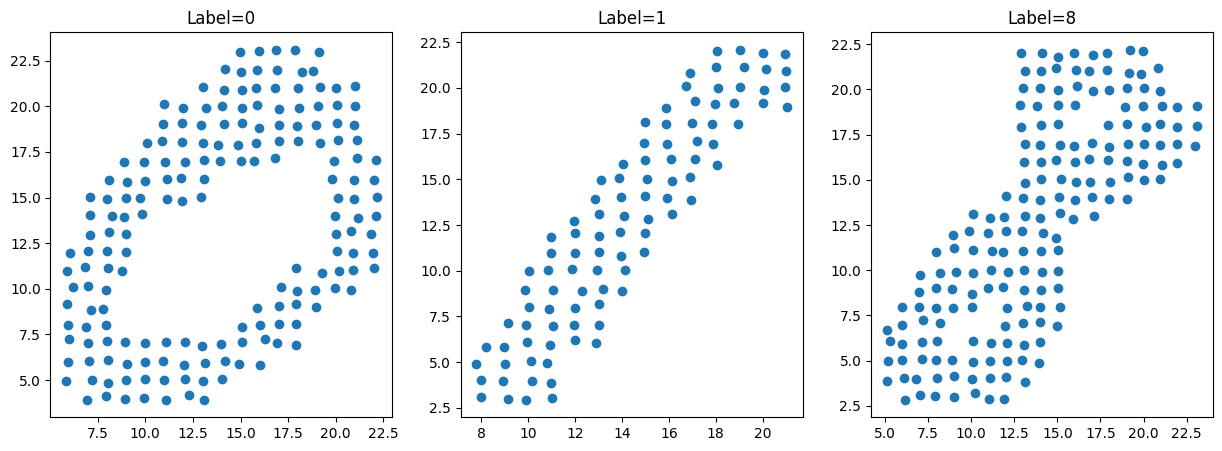

In [3]:
with open('./data/data.pkl','rb') as f:
    X,y=pickle.load(f)
inds = [0,25,51]
fig,ax = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    ax[i].scatter(X[inds[i]][:,0],X[inds[i]][:,1])
    ax[i].set_title('Label=%d'%y[inds[i]])

### 1.6.3 - Calculate Persistence Diagrams using the Ripser package

Now we are ready to calculate the persistence diagrams using the Ripser package.

Rips(maxdim=1, thresh=100.0, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


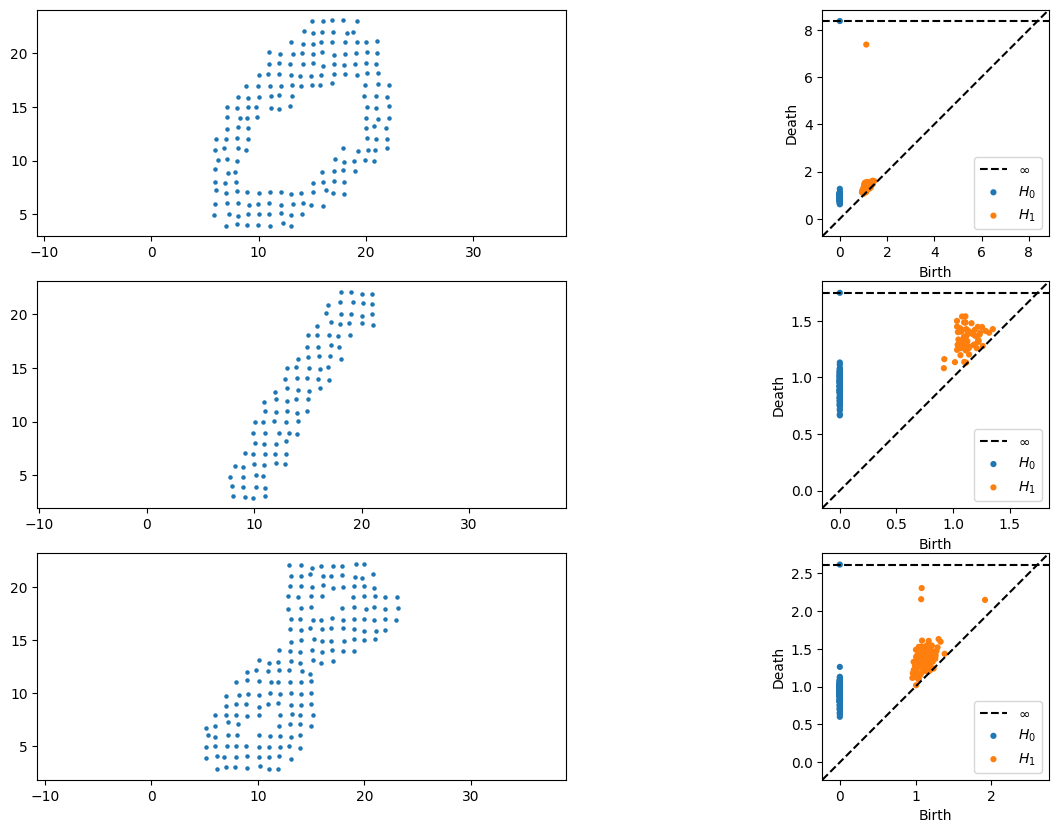

In [4]:
rips = Rips(thresh=1e+2)
fig, axs = plt.subplots(3,2,figsize=(15,10))
for n,i in enumerate(inds):        
    plt.axes(axs[n,0])
    plt.scatter(X[i][:,0],X[i][:,1],s=5)
    plt.axis('equal')
    D=rips.fit_transform(X[i])
    plt.axes(axs[n,1])
    rips.plot(D)

Now we calculate the PDs for all point sets. We will do our analysis based on $H_1$ and to avoid $\infty$ we will set all the $\infty$ values to a large float. 

In [5]:
rips = Rips()
PD = []
for p in X:   
    D = rips.fit_transform(p)
    D = D[1]
    D[D[:,1]==np.inf,1]=1e+2
    PD.append(D)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


### 1.6.4 - Calculating pairwise distances

Here, we first develop a simple function that receives two persistence diagrams, $\mu$ (diagram1) and $\nu$ (diagram2) and then calculate the distance between them through $OT(\tilde{\mu},\tilde{\nu})$.

In [6]:
def otPD(diagram1,diagram2,p=2):
    '''
    This function calculates an optimal partial transport problem 
    between to persistence diagrams.
    
    Inputs
        diagram1 :  A Nx2 numpy array where diagram[:,0] is birth and diagram[:,1] is death
        diagram2 :  A Mx2 numpy array where diagram[:,0] is birth and diagram[:,1] is death
        
    Outputs
        w2 : 2-Wasserstein distance
        pi : The optimal partial transport plan    
    '''
    N, M = diagram1.shape[0], diagram2.shape[0]
    
    # Calculate diagonal projections per diagram
    diagram1_diagonal_projection = np.stack([diagram1.mean(1),diagram1.mean(1)],1)
    diagram2_diagonal_projection = np.stack([diagram2.mean(1),diagram2.mean(1)],1)

    # Extend both diagrams by the diagonally projected elements from the other diagram, i.e., $\tilde{\mu}$ and $\tilde{\nu}$
    diagram1_extended = np.concatenate([diagram1, diagram2_diagonal_projection],0) # Now (N+M)x2
    diagram2_extended = np.concatenate([diagram2, diagram1_diagonal_projection],0) # Now (N+M)x2
    
    # Calculate the OT problem between $\tilde{\mu}$ and $\tilde{\nu}$
    mass = np.ones((N+M,))/(N+M)
    cost_matrix = ot.dist(diagram1_extended, diagram2_extended,p=p) # Calculate the cost matrix
    cost_matrix[N:,M:] = 0
    pi, log = ot.emd(mass,mass,cost_matrix,log=True)    
    return np.power(log['cost'],1/p), pi[:N,:M]

Next we calculate the pairwise distances between the diagrams. 

Wall clock time for calculating pairwise distances between 75 PDs = 6.361745 secs


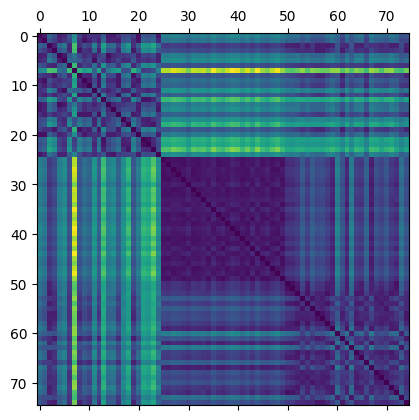

In [7]:
K = len(X)
PD_Dist = np.zeros((K,K))
tic = time.time()
for i in range(K-1):
    for j in range(i+1,K):
        PD_Dist[i,j]=otPD(PD[i],PD[j],p=2)[0]
toc = time.time()
PD_Dist = PD_Dist+PD_Dist.T
plt.matshow(PD_Dist)
print('Wall clock time for calculating pairwise distances between %d PDs = %f secs'%(K,toc-tic))

### 1.6.5 - Manifold learning using the pairwise distances

Now that we have the pairwise distances, we can embedd the persistence diagrams in a d-dimensional vector space using various manifold learning approaches. We first show the results for Multi-Dimensional Scaling (MDS) for embedding the PDs into a 2-dimensional vector space. 

In [8]:
### Calculate MDS Embedding        
np.random.seed(0)
mds = MDS(n_components=2,dissimilarity='precomputed',normalized_stress='auto',n_init=10)
Z = mds.fit_transform(PD_Dist)

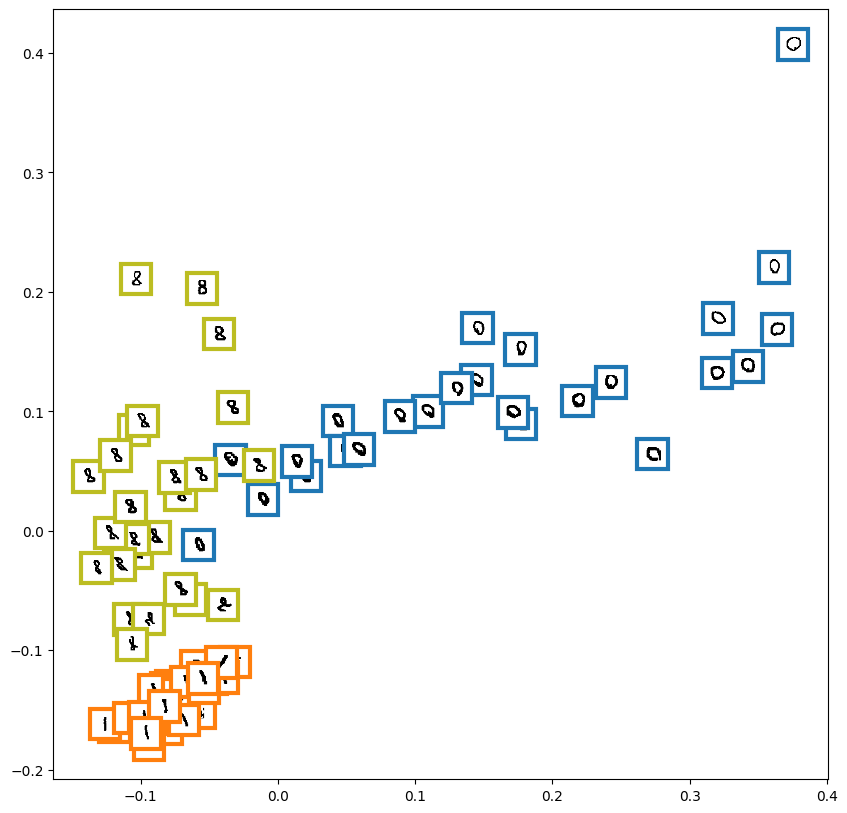

In [9]:
### Generate thumbnail images
img=np.zeros((len(X),28,28))
for n in range(len(X)):
    inds = np.round(X[n]).astype('uint8')
    for i,j in inds:
        img[n,i,j]=1
### Visualize Embedded Points
fig,ax = plt.subplots(1,1,figsize=(10,10))
for i,label in enumerate(np.unique(y)):
    ax.scatter(Z[np.array(y)==label,0],Z[np.array(y)==label,1],c='C%d'%i,label=str(label),s=100)
for i in range(Z.shape[0]):
    imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img[i,...].T, cmap=plt.cm.gray_r,zoom=.5), Z[i,:],
            bboxprops =dict(edgecolor='C%d'%y[i],linewidth=3)
        )
    imagebox.set(zorder=1)
    ax.add_artist(imagebox)

Next, we try another classic manifold learning approach Isomap. 

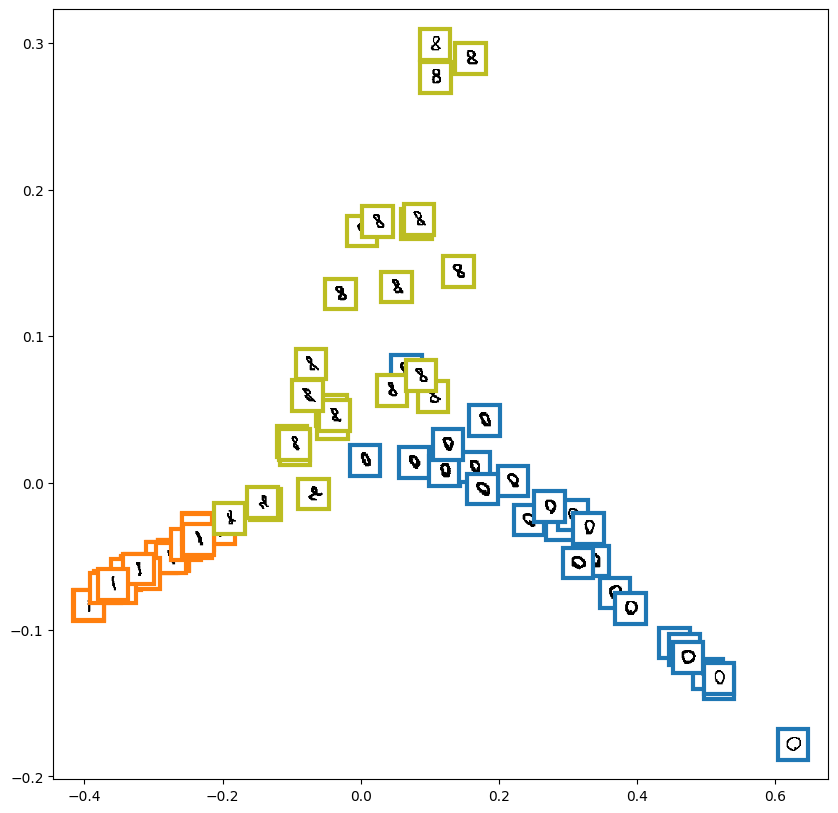

In [10]:
np.random.seed(0)
isomap=Isomap(n_neighbors=5,metric='precomputed')
Z_iso=isomap.fit_transform(PD_Dist)
fig,ax = plt.subplots(1,1,figsize=(10,10))
for i,label in enumerate(np.unique(y)):
    ax.scatter(Z_iso[np.array(y)==label,0],Z_iso[np.array(y)==label,1],
               c='C%d'%i,label=str(label),s=100)
for i in range(Z_iso.shape[0]):
    imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(img[i,...].T, cmap=plt.cm.gray_r,zoom=.5), Z_iso[i,:],
            bboxprops =dict(edgecolor='C%d'%y[i],linewidth=3)
        )
    imagebox.set(zorder=1)
    ax.add_artist(imagebox)

<a id='references'></a>
## References

[1] Rabin, Julien, Gabriel Peyré, Julie Delon, and Marc Bernot. "Wasserstein barycenter and its application to texture mixing." In Scale Space and Variational Methods in Computer Vision: Third International Conference, SSVM 2011, Ein-Gedi, Israel, May 29–June 2, 2011, Revised Selected Papers 3, pp. 435-446. Springer Berlin Heidelberg, 2012.

[2] Carriere, Mathieu, Marco Cuturi, and Steve Oudot. "Sliced Wasserstein kernel for persistence diagrams." In International conference on machine learning, pp. 664-673. PMLR, 2017.